# overall workflow

## data acquisition
We scrape data from Tagesspiegel, a Berlin based newspaper covering local, national and international topics.

In [256]:
from datetime import date
from data_acquisition import scrape_tsp as st

In [257]:
str(date.today())

'2020-09-07'

In [258]:
st.get_links()

<Response [200]>


'wrote 158 links to data_acquisition/links-tsp-2020-09-07.txt'

In [259]:
scraped_file = 'data_acquisition/links-tsp-' + str(date.today()) + '.txt'
st.select_new_links(scraped_file)

Before running the next cell, update the integer number in st.get_content( .. , int , ...)

Should be updated to the numer that was returned the last time the cell ran.

In [260]:
#%run 'data-acquisition/get-content-02.py'
#from data_acquisition import get_content_tsp_03

import os

path_to_link_file= 'data_acquisition/links-tsp-'+str(date.today())+'-new.txt'
path_to_output_folder='tagesspiegel-'+str(date.today())

_, dirs, _ = next(os.walk(os.getcwd()))

if path_to_output_folder in dirs:
    print("** folder exists **")
else:
    os.mkdir(path_to_output_folder, mode=0o744) 

#print(path_to_output_folder)
st.get_content(path_to_link_file,1257,path_to_output_folder)

1382

When articles are downloaded, add new links to 'bestand'
in unix: cat file_with_new_links >> bestands_file

In [ ]:
# use cat in unix or copy paste by hand

## data cleaning
 1. We check for advertisement in the articles' text. Ad text is included in brackets [...]
 2. We check for empty authors. 
 3. We check for missing date of publication
 4. We check for press releases
 
ad 2: An empty list of authors is replaced by the name of the paper: Tagesspiegel.

ad 4: An article that is a press release has closing characters (tsp) or (tsp,dpa) or similar. We remove the parenthesis and the enclosed text.

In [7]:
from data_cleaning import clean_tsp_02 as ct

In [261]:
ct.clean_up('tagesspiegel-2020-09-07','2020-09-07')

tagesspiegel-2020-09-07/01337.json
tagesspiegel-2020-09-07/01288.json


{'files inspected': 123,
 'files with ads': 65,
 'ads removed': 80,
 'files removed': 2,
 'files removed reasons': ['too short', 'wrong type: imagegallery'],
 'dates imputed': 5}

In [5]:
ct.clean_up('tagesspiegel-2020-08-02','2020-08-02')

tagesspiegel-2020-08-02/00843.json
tagesspiegel-2020-08-02/00859.json
tagesspiegel-2020-08-02/00878.json
tagesspiegel-2020-08-02/00840.json


{'files inspected': 78,
 'files with ads': 43,
 'ads removed': 64,
 'files removed': 4,
 'files removed reasons': ['wrong type: author',
  'wrong type: imagegallery',
  'too short',
  'too short'],
 'dates imputed': 6}

In [3]:
ct.clean_up('tagesspiegel-2020-09-04','2020-09-04')

tagesspiegel-2020-09-04/01126.json
tagesspiegel-2020-09-04/01045.json
tagesspiegel-2020-09-04/01048.json


{'files inspected': 138,
 'files with ads': 61,
 'ads removed': 81,
 'files removed': 3,
 'files removed reasons': ['wrong type: imagegallery',
  'wrong type: imagegallery',
  'wrong type: imagegallery'],
 'dates imputed': 9}

In [4]:
ct.clean_up('tagesspiegel-2020-08-04','2020-08-04')

tagesspiegel-2020-08-04/00973.json
tagesspiegel-2020-08-04/01016.json
tagesspiegel-2020-08-04/00914.json


{'files inspected': 118,
 'files with ads': 60,
 'ads removed': 74,
 'files removed': 3,
 'files removed reasons': ['too short',
  'wrong type: imagegallery',
  'too short'],
 'dates imputed': 6}

In [8]:
ct.clean_up('tagesspiegel-2020-09-05','2020-09-05')

tagesspiegel-2020-09-05/01239.json


{'files inspected': 89,
 'files with ads': 40,
 'ads removed': 51,
 'files removed': 1,
 'files removed reasons': ['too short'],
 'dates imputed': 7}

## ml task

In [262]:
import os

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

import re

from textblob_de import TextBlobDE 

import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import math

import json


def preprocessing_02 (text):
    #print(text)
    a = text.lower() # lower cases only
    b = re.sub("(\\W|\\d)"," ",a) #remove non-ascii and digits
    blob = TextBlobDE(b)
    return(blob.words.lemmatize()) # lemmatize for german


def read_articles_transform_to_df (path_to_text_files='../tagesspiegel/*.txt'):

	file_list=glob.glob(path_to_text_files)
	#file_list = glob.glob("../tagesspiegel/*.txt")
	#print(file_list)

	n = len(file_list)
	print(n , "files to work with.")

	#list_of_articles = []
	X = pd.DataFrame(columns=['file','text'])
	#print('df', X)

	for i in range(n):
		with open (file_list[i]) as file:
			text_1 = file.read()
			text_2 = json.loads(text_1)
			text_3 = text_2['text']
			text=' '.join(preprocessing_02(text_3))
			#print(text)
			X=X.append({'file':file_list[i] , 'text':text}, ignore_index=True)
	#print(X.shape)
	return(X)

def enthropy(pv):

	# should check, that all values are positive and sum to (about) 1
	return(-sum([pv[i]*math.log(pv[i]) for i in range(len(pv))]))

def evaluate_cluster(km_object):
	n, bins, patches = plt.hist(km_object.labels_, km_object.n_clusters, facecolor='blue', alpha=0.5)
	plt.title('sizes of clusters')
	plt.ylabel('nr. of articles')
	plt.show()

	rel_fq = [round(ni/sum(n),3) for ni in n] 
#		print('elements in bins: ' , n)
#		print('relative size of bins: ', rel_fq)
#		print('enthropy: ', enthropy(rel_fq))

	return({'n': n , 'frequencies': rel_fq , 'enthropy': enthropy(rel_fq), 'inertia':km_object.inertia_})

preprocessing does some basic transfomation of a text into a wordlist:

Remove non ascii symbols and numbers / digits.

Remove punctuation. Lemmatize.

In [263]:
preprocessing_02('Ich, meiner, mir, mich. Hallo hier ist ein Baum. %§/$. Oder 8 oder 9 oder 77 bzw. zwölf?? Läuft lief gelaufen')
print(li)

['ich', 'meinern', 'mir', 'mich', 'hallo', 'hier', 'sein', 'ein', 'baum', 'oder', 'oder', 'oder', 'bzw', 'zwölf', 'laufen', 'laufen', 'laufen']


In [264]:
X = read_articles_transform_to_df('tagesspiegel_01/*clean.json')
X['text'][0] # to check what we work with: Umlaute are correct, Data cleaning should have removed advertising text ...

615 files to work with.


'dass australien heuen ein weinexportnation sein haben das land deutsch flüchtlingen zu verdanken siedelten sich im barossa valley lutheraner an die aus grünberg in schlesien vertreiben worden sein um auch in der fremd messwein für ihre gottesdienste keltern zu können haben sie rebstöcke von zu hause mitgebracht auchen das australisch musikleben haben deutsch wurzeln von den nationalsozialisten vertriebene künstler haben hier ein klassik szene nach europäischem vorbild aufbauen musica viva australia von dem berliner walter dullo und dem wiener richard goldner gründen sein heuen die grösst kammermusikorganisation der welt albrecht dümling weeissen dutzende solch geschichten zu erzählen seit zwei jahrzehnten beschäftigen er sich mit dem thema musik und exiln seit jahren leitet er den berliner verein musica reanimata der es sich zur aufgabe machen haben die werke der vertriebenen künstler zu neuem leben zu erwecken und das heeissen im falle der musik nun einmal aufführungen zu organisiere

In [265]:
list_of_articles = X['text']

cv = TfidfVectorizer(max_df=0.8 , min_df =2)
#print('cv: ' , dir(cv))
km =  KMeans(init='k-means++', n_clusters=5, n_init=10)

text_cluster = Pipeline([('vect', cv), ('cluster', km) ])

#text_cluster.fit(list_of_articles[0:100])
text_cluster.fit(list_of_articles)

#labels_as_column = pd.DataFrame(km.labels_)
#print(type(labels_as_column), labels_as_column.shape)

X['cluster'] = pd.DataFrame(km.labels_) # contains labels
#print(X)

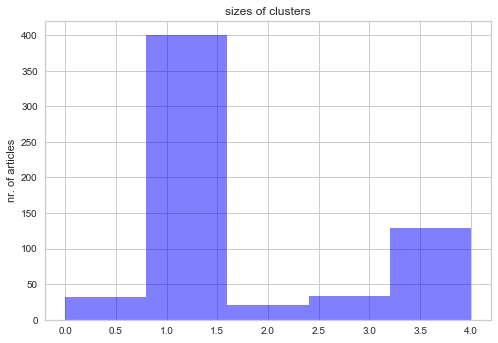

['aachener',
 'ab',
 'abbau',
 'abbauen',
 'abbiegen',
 'abbilden',
 'abbrechen',
 'abc',
 'abd',
 'abdankung']

In [266]:
evaluate_cluster(km)
cv.get_feature_names()[0:10]

How to represent a cluster? 
The centroid is a numerical vector, has to be translated back into words. But how?

In [267]:
centers = np.array(km.cluster_centers_)
print(centers.shape)


(5, 17310)


In [209]:
#!pip install wordcloud

In [268]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # don't need english STOPWORDS
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [269]:
# this variable can be imported from wordcloud, but then it is a list of english stoppwords
STOPWORDS = {'jedoch','auch','des','dies','als','wie','dem','den','um','mit','sein','auf','der','die','das','und','ein','aus','kein','wir','ihr','er','dass','du','ich','mein','mich','dein','dir','dich'}
print(STOPWORDS)
# Does not heplt, these word still come up in the word cloud. No idea why.

{'ich', 'des', 'als', 'wie', 'mein', 'wir', 'ihr', 'dass', 'die', 'auch', 'mit', 'und', 'dich', 'das', 'aus', 'dem', 'kein', 'dir', 'den', 'du', 'jedoch', 'dies', 'mich', 'dein', 'um', 'sein', 'ein', 'der', 'er', 'auf'}


In [270]:
text = [w for w in X['text'][2].split() if w in cv.get_feature_names()]
' '.join(text)

'er machen angst bange so er birol ünel kaputt barkeeper fatih akins liebesdrama gegen wand um kopf spielte er dies verloren menschen gerade so grenzen seines dabeien sprengte immer seinem namen verbinden birol ünel kommen fasen aus nichts vor jahren haute um film seine darsteller erhielt golden bären dafüren european film awards preise jen jahr fall lieb retten später fatih akins soul kitch spielte ünel koch er oft dies heftig unberechenbaren aggressiv typen gespielt gangster mut wild selten türkisch silifke gebären wuchs birol ünel nähe bremen studiert schauspiel hannover geben thomas passagier welcome to germany kz seite tony birol ünel cahit fatih akins gegen wand foto imago united neunzigern spielte er theater führen regie berliner kunsthaus tacheles treten bei frank castorf siegfried dess nibelungen born bad nochen so draufgänger passt heinrich tv er sehen man kannte ihn trotzdem kaum bis fatih akin ihm dies hauptrolle geben durchbruch später blieb meistens bei kino fernsehen bir

In [276]:
my_stopper = ['es','zu','werden','haben','sein','von','jedoch','auch','des','dies','als','wie','dem','den','um','mit','sein','auf','der','die','das','und','ein','aus','kein','wir','ihr','er','dass','du','ich','mein','mich','dein','dir','dich']
[w in cv.get_feature_names() for w in my_stopper]

[False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [273]:
text = [w for w in X['text'][3].split() if w not in my_stopper]
[w in text for w in my_stopper]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

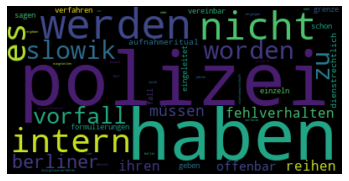

In [277]:
wordcloud = WordCloud().generate(' '.join(text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# this is strange, there are words from my stoplist in the wordcloud.
# These words were never an argument to the wordcloud generation ?? !!

Collect all text from a specified cluster and create its wordcloud.

In [250]:
#df.loc[df['column_name'] == some_value]
Xcl = X.loc[X['cluster']==2]['text']
Xcl.shape

(9,)

i.split():  ['es', 'sein', 'der', 'zweit', 'schock', 'für', 'die', 'nation', 'innerhalb', 'von']
list comp ['zweit', 'schock', 'für', 'nation', 'innerhalb', 'stunden', 'eren', 'wegen', 'virus', 'epidemie']
t: zweit scho
i.split():  ['der', 'bankenverband', 'sein', 'wegen', 'des', 'cum', 'ex', 'steuerskandals', 'ins', 'visier']
list comp ['bankenverband', 'wegen', 'cum', 'ex', 'steuerskandals', 'ins', 'visier', 'ermittler', 'geraten', 'am']
t: zweit scho
i.split():  ['weiter', 'sechs', 'ex', 'banker', 'und', 'ein', 'ehemalig', 'anwalt', 'ein', 'renommiert']
list comp ['weiter', 'sechs', 'ex', 'banker', 'ehemalig', 'anwalt', 'renommiert', 'rechtsanwaltskanzlei', 'müssen', 'sich']
t: zweit scho
i.split():  ['Staatsanwälte', 'und', 'steuerfahnder', 'ermitteln', 'seit', 'jahren', 'zu', 'umstritten', 'cum', 'ex']
list comp ['Staatsanwälte', 'steuerfahnder', 'ermitteln', 'seit', 'jahren', 'umstritten', 'cum', 'ex', 'aktiendeals', 'am']
t: zweit scho
i.split():  ['die', 'neust', 'enthüllungen'

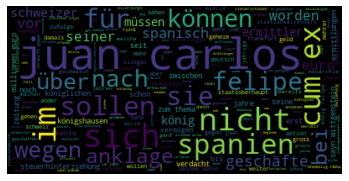

In [282]:
t1 = ''
for i in Xcl:
    print('i.split(): ', i.split()[0:10])
    print('list comp', [w for w in i.split() if w not in my_stopper][0:10])
    t1 += ' '.join([w for w in i.split() if w not in my_stopper])
    print('t:', t1[0:10])
print('stopwords still included? : ', [ w in t1 for w in my_stopper])
#print('von' in my_stopper)
wordcloud = WordCloud().generate(t1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [288]:
import operator

document = ["One Geek helps Two Geeks", 
            "Two Geeks help Four Geeks", 
            "Each Geek helps many other Geeks at GeeksforGeeks"] 
  
# Create a Vectorizer Object 
vectorizer = CountVectorizer() 
  
vectorizer.fit([t1]) 
  
# Printing the identified Unique words along with their indices 
#print("Vocabulary: ", vectorizer.vocabulary_) 
  
# Encode the Document 
vector = vectorizer.transform([t1]) 
  
# Summarizing the Encoded Texts 
#print("Encoded Document is:") 
#print(vector.toarray())

sorted_x = sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))



[('öffentlichkeit', 1529), ('öfter', 1530), ('ölstaates', 1531), ('über', 1532), ('überhaupt', 1533), ('überlegt', 1534), ('übernehmen', 1535), ('überschuldung', 1536), ('überwies', 1537), ('übrigens', 1538)]


In [289]:
print(sorted_x[len(sorted_x)-100:len(sorted_x)])

[('wiesbaden', 1439), ('willen', 1440), ('wird', 1441), ('wirtschaftlich', 1442), ('wirtschaftsdelikte', 1443), ('wirtschaftskriminalität', 1444), ('wirtschaftskrise', 1445), ('wirtschaftsstrafkammer', 1446), ('wissen', 1447), ('wittgenstein', 1448), ('wittgensteins', 1449), ('woch', 1450), ('wochenende', 1451), ('wohnen', 1452), ('wollen', 1453), ('wonach', 1454), ('worden', 1455), ('wortgleich', 1456), ('worumen', 1457), ('wurde', 1458), ('wurden', 1459), ('wurzeln', 1460), ('währen', 1461), ('während', 1462), ('wäscht', 1463), ('wüsten', 1464), ('york', 1465), ('zahl', 1466), ('zahlen', 1467), ('zahlreich', 1468), ('zahlte', 1469), ('zahlungen', 1470), ('zarzuela', 1471), ('zehn', 1472), ('zeiten', 1473), ('zeitpunkt', 1474), ('zeitung', 1475), ('zeugen', 1476), ('zeugenaussagen', 1477), ('zeugenstatus', 1478), ('ziehen', 1479), ('ziel', 1480), ('zuckerfabrikant', 1481), ('zuckerrohr', 1482), ('zudem', 1483), ('zudemen', 1484), ('zuflucht', 1485), ('zufolge', 1486), ('zug', 1487), (

## presentation as html , website